# CSC 591/ECE 592: Constraint Satisfiability Final Project Code
## All code used in this project was developed solely by ourselves.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.ibmq import least_busy
provider = IBMProvider()
print(provider.backends())
# backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > (n - 1) and x.status().operational == True)

[<IBMBackend('ibm_algiers')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibmq_kolkata')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_nazca')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_cairo')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_cusco')>]


In [3]:
IBMProvider.save_account(token='d7f804e6068832550b06b8c8cec358a85569d145cb9aec40cfa54e7309c84372ac41be766b0ef3932768b77c596525e323dc9fc90dbcfa8a3fb97a10ce766026', overwrite=True)

In [4]:
# Sat oracle
def sat_oracle(qc, n,m, clause_list, aux, f_in,ans):
    i = 0
    main_string = ''
    control_target_qubits = []
    for clause in clause_list:
        ctrl_string = ''
        for var in clause:
            # making the control string for the toffoli gate
            # if negative literal then target flipped when control is 1 else flipped when it is 0
            if(var < 0):
                ctrl_string = ctrl_string + '1'
            else:
                ctrl_string = ctrl_string + '0'
        ctrl_string_rev = ctrl_string[::-1]
        qc.append(qiskit.circuit.library.MCXGate(3, ctrl_state=ctrl_string_rev), [abs(clause[0])-1,abs(clause[1])-1,abs(clause[2])-1,aux[i]])
        main_string = main_string + '1'
        control_target_qubits.append(aux[i])
        i = i+1
    control_target_qubits.append(ans)
    # m input toffoli gate to check the truth value of the entire sentence
    qc.append(qiskit.circuit.library.MCXGate(m, ctrl_state=main_string), control_target_qubits)
    clause_list_rev = clause_list[::-1]
    i = i-1
    # this is the uncomputation to get rid of garbage values
    for clause in clause_list_rev:
            ctrl_string = ''
            for var in clause:
                if(var < 0):
                    ctrl_string = ctrl_string + '1'
                else:
                    ctrl_string = ctrl_string + '0'
            ctrl_string_rev = ctrl_string[::-1]
            qc.append(qiskit.circuit.library.MCXGate(3, ctrl_state=ctrl_string_rev), [abs(clause[0])-1,abs(clause[1])-1,abs(clause[2])-1,aux[i]])
            i = i-1      

In [5]:
# diffuser :- acts on the out qubit only when it is in - state
def diffuser(qc,f_in,n,out):
    diffuse = []
    for i in range(n):
        qc.h(f_in[i])
        qc.x(f_in[i])
        diffuse.append(f_in[i])
    qc.x(ans)
    qc.h(ans)
    diffuse.append(ans)
    qc.append(qiskit.circuit.library.MCXGate(n), diffuse)
    diffuse = []
    for i in range(n):
        qc.x(f_in[i])
        qc.h(f_in[i])
    qc.h(ans)
    qc.x(ans)

In [6]:
clause_list = [[1,-3,-4],[2,-3,-4],[1,2,3],[-1,2,-3]]  
n = 4 # n is the number of variables
m=4 # m is the number of clauses

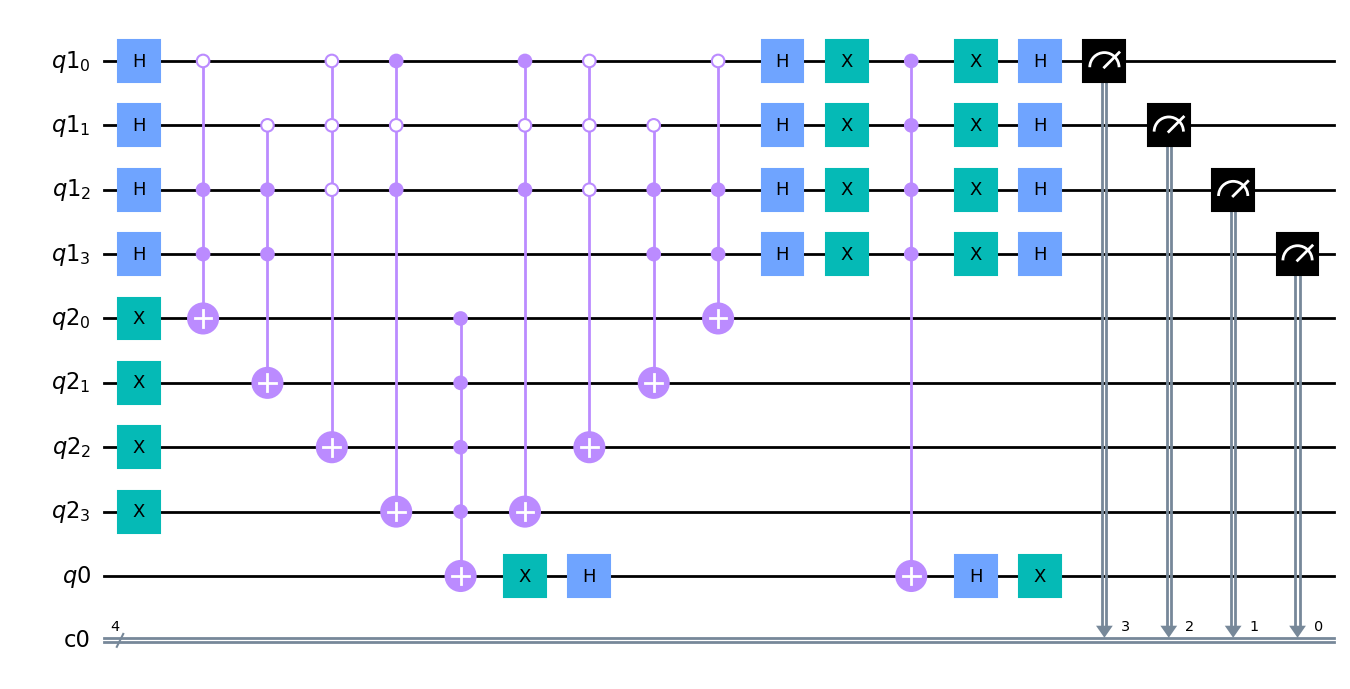

In [7]:
ans = QuantumRegister(1)
output = ClassicalRegister(n)
f_in = QuantumRegister(n)
aux = QuantumRegister(m)
qc = QuantumCircuit()
qc.add_register(f_in)
qc.add_register(aux)
qc.add_register(ans)
qc.add_register(output)
#initializing the n variable quibits
for i in range(n):
    qc.h(f_in[i])
#initilaizing the auxilliary qubits to 1, aux bits flipped only when the clause is false
for i in range(m):
    qc.x(aux[i])
p = 1 # number of time oracle + diffuser is repeated
for p1 in range(p):
    sat_oracle(qc,n,m,clause_list,aux,f_in,ans)
    diffuser(qc,f_in,n,ans)
    
# measuring the qubits

j = n-1
for i in range(n):
    qc.measure(f_in[i],output[j])
    j = j-1
    
qc.draw('mpl', style="clifford")


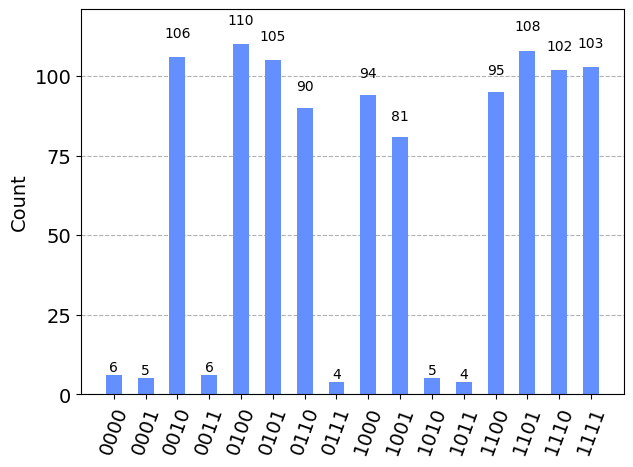

In [8]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

#### 

In [9]:
qc.metadata = {}

In [10]:
backend = provider.get_backend("ibm_nazca")
#least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > qc.num_qubits and x.status().operational == True))
print("least busy backend: ", backend)
print(backend.configuration().n_qubits)

least busy backend:  <IBMBackend('ibm_nazca')>
127


In [11]:
transpiled_qc = transpile(qc, backend=backend)
print(transpiled_qc.metadata)
#print("Transpiled Circuit:\n", transpiled_qc)
print("Transpiled Circuit Num Qubits:\n", transpiled_qc.num_qubits)

{}
Transpiled Circuit Num Qubits:
 127


{}
Transpiled Circuit Num Qubits:
 127
Job Status: job has successfully run


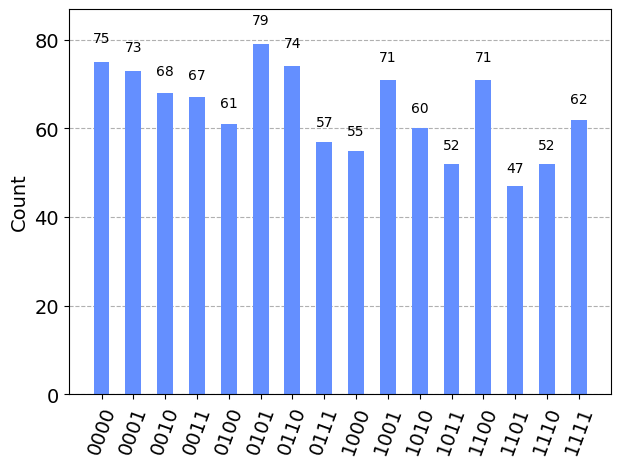

In [12]:
transpiled_qc = transpile(qc, backend=backend)
print(transpiled_qc.metadata)
#print("Transpiled Circuit:\n", transpiled_qc)
print("Transpiled Circuit Num Qubits:\n", transpiled_qc.num_qubits)

from qiskit.tools.monitor import job_monitor

shots = 1024
job = backend.run(transpiled_qc, shots=shots)

job_monitor(job, interval=2)

results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In [13]:
clause_list = [[-1,-2,3],[-1,-2,-3],[1,2,3]]
n = 3
m=3

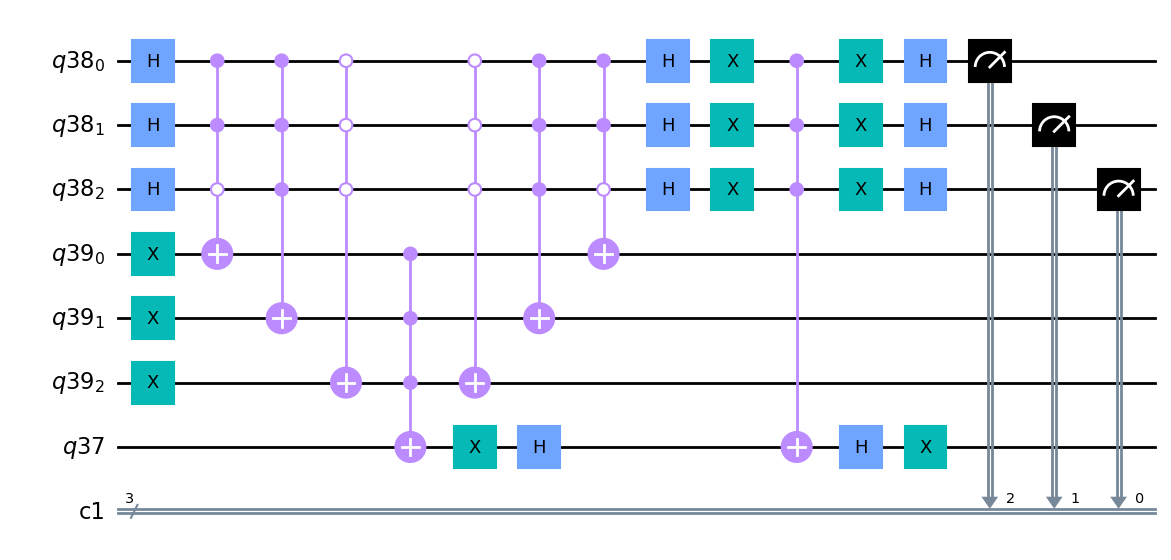

In [14]:
ans = QuantumRegister(1)
output = ClassicalRegister(n)
f_in = QuantumRegister(n)
aux = QuantumRegister(m)
qc = QuantumCircuit()
qc.add_register(f_in)
qc.add_register(aux)
qc.add_register(ans)
qc.add_register(output)
for i in range(n):
#     qc.x(f_in[i])
    qc.h(f_in[i])
for i in range(m):
    qc.x(aux[i])
p = 1
for p1 in range(p):
    sat_oracle(qc,n,m,clause_list,aux,f_in,ans)
    diffuser(qc,f_in,n,ans)
    
# half_sat_oracle(qc,n,m,clause_list,aux,f_in,ans)



j = n-1
for i in range(n):
    qc.measure(f_in[i],output[j])
    j = j-1
# qc.measure(ans,output)
    
qc.draw('mpl', style="clifford")

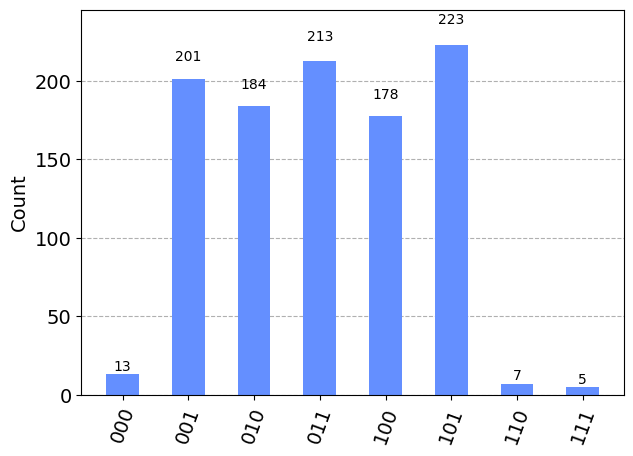

In [15]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

{}
Transpiled Circuit Num Qubits:
 127
Job Status: job has successfully run


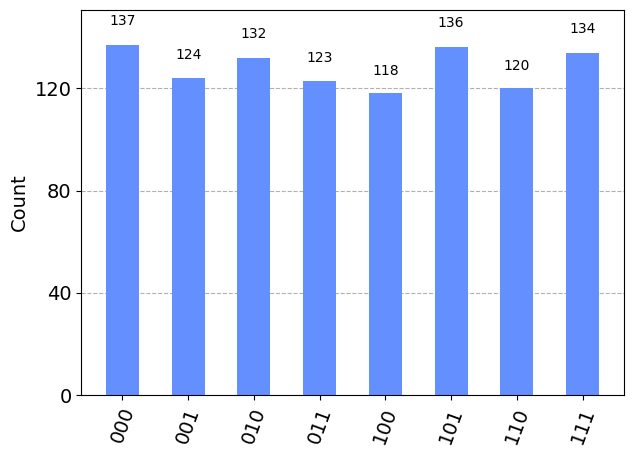

In [16]:
transpiled_qc = transpile(qc, backend=backend)
print(transpiled_qc.metadata)
#print("Transpiled Circuit:\n", transpiled_qc)
print("Transpiled Circuit Num Qubits:\n", transpiled_qc.num_qubits)

from qiskit.tools.monitor import job_monitor

shots = 1024
job = backend.run(transpiled_qc, shots=shots)

job_monitor(job, interval=2)

results = job.result()
answer = results.get_counts()

plot_histogram(answer)

In [17]:
clause_list = [[-1,-2,3],[-1,-2,-3],[1,2,-3]]
n = 3
m=3

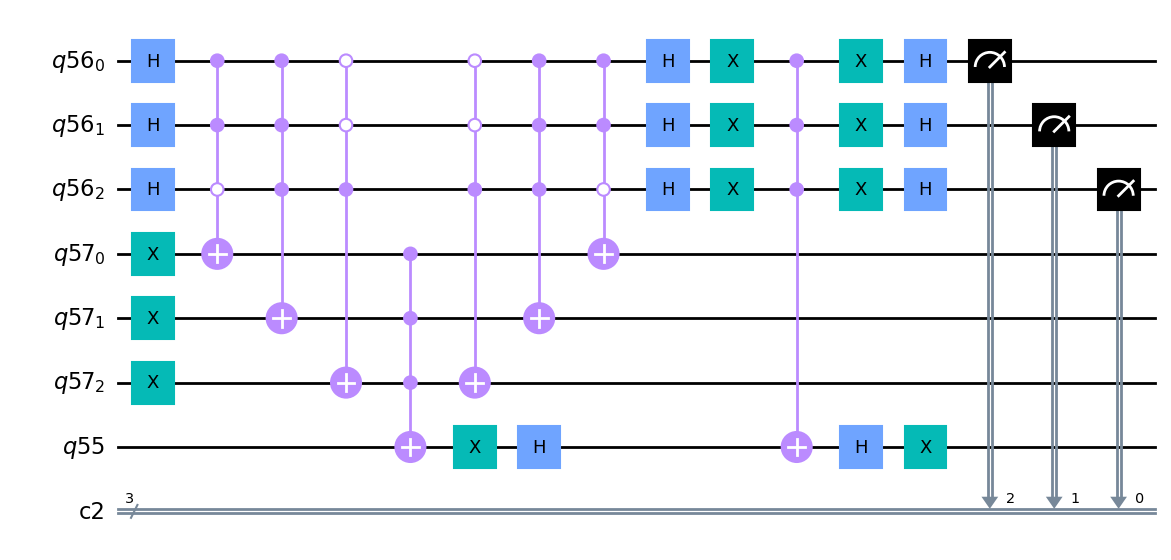

In [18]:
ans = QuantumRegister(1)
output = ClassicalRegister(n)
f_in = QuantumRegister(n)
aux = QuantumRegister(m)
qc = QuantumCircuit()
qc.add_register(f_in)
qc.add_register(aux)
qc.add_register(ans)
qc.add_register(output)
for i in range(n):
#     qc.x(f_in[i])
    qc.h(f_in[i])
for i in range(m):
    qc.x(aux[i])
p = 1
for p1 in range(p):
    sat_oracle(qc,n,m,clause_list,aux,f_in,ans)
    diffuser(qc,f_in,n,ans)
    
# half_sat_oracle(qc,n,m,clause_list,aux,f_in,ans)



j = n-1
for i in range(n):
    qc.measure(f_in[i],output[j])
    j = j-1
# qc.measure(ans,output)
    
qc.draw('mpl', style="clifford")

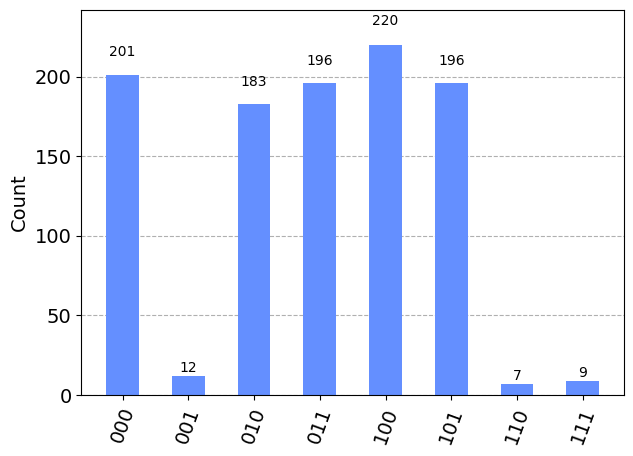

In [19]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

In [20]:
clause_list = [[-4, -2, -1], [-4, 1, 2], [-3, -2, 1], [-2, 1, 3], [-1, 2, 3], [-1, 3, 4]]  #19
n = 4
m = 6

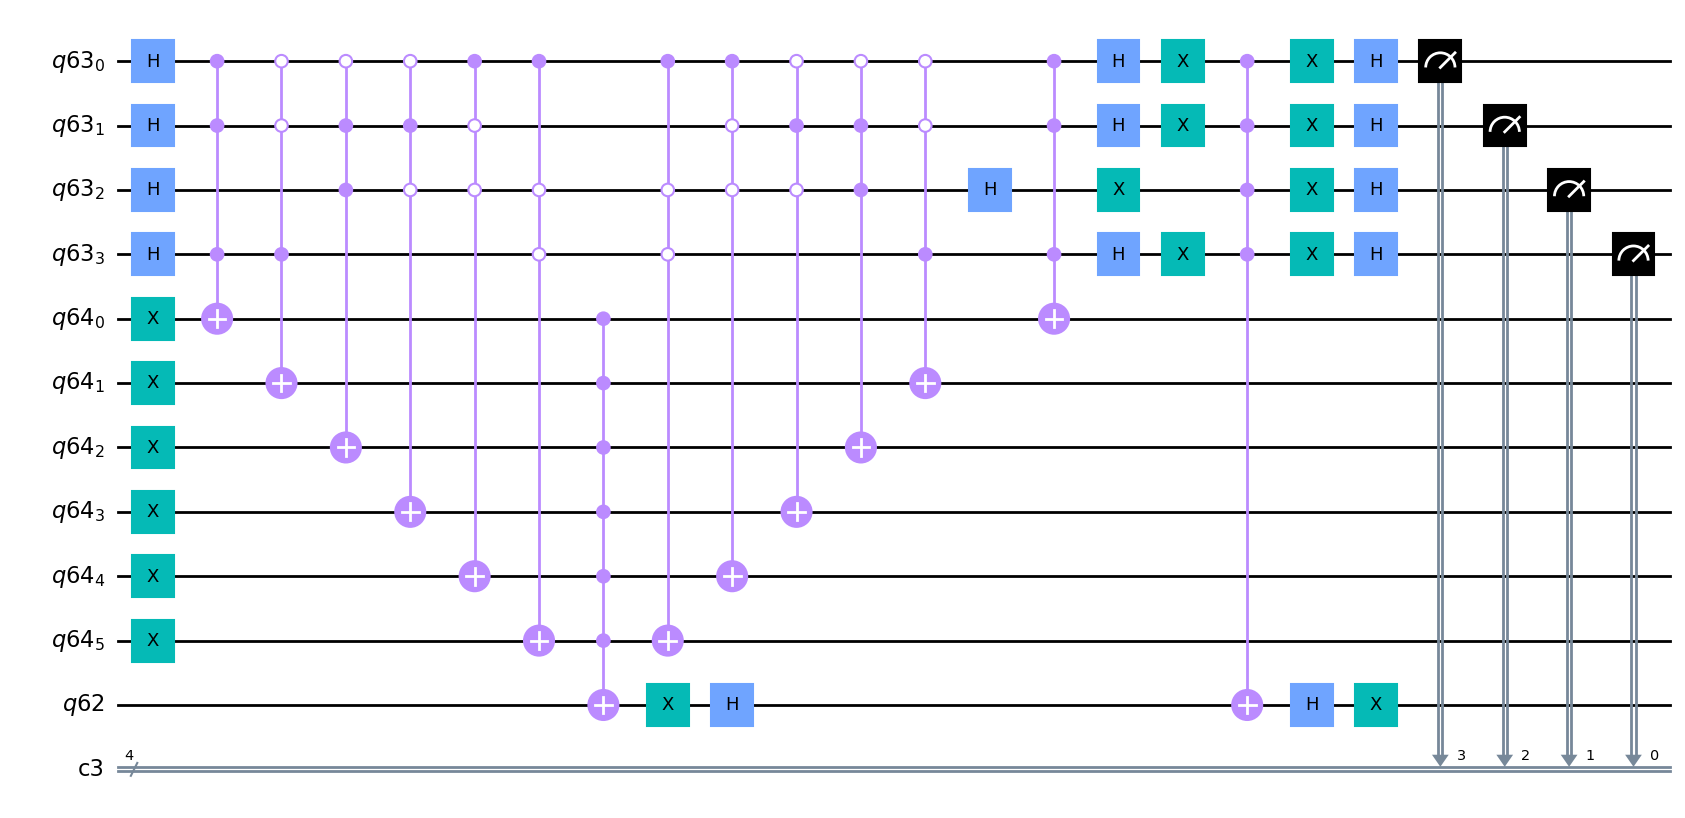

In [21]:
ans = QuantumRegister(1)
output = ClassicalRegister(n)
f_in = QuantumRegister(n)
aux = QuantumRegister(m)
qc = QuantumCircuit()
qc.add_register(f_in)
qc.add_register(aux)
qc.add_register(ans)
qc.add_register(output)
for i in range(n):
#     qc.x(f_in[i])
    qc.h(f_in[i])
for i in range(m):
    qc.x(aux[i])
p = 1
for p1 in range(p):
    sat_oracle(qc,n,m,clause_list,aux,f_in,ans)
    diffuser(qc,f_in,n,ans)
    
# half_sat_oracle(qc,n,m,clause_list,aux,f_in,ans)



j = n-1
for i in range(n):
    qc.measure(f_in[i],output[j])
    j = j-1
# qc.measure(ans,output)
    
qc.draw('mpl', style="clifford")

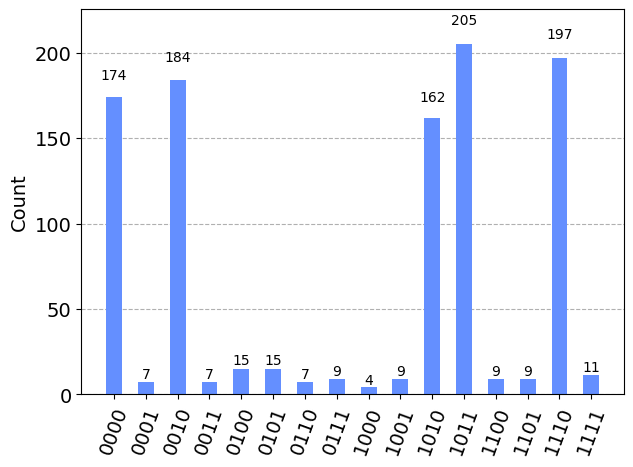

In [22]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

# Finding the critical ratio

In [23]:
import random
import itertools
import csv
import numpy as np
import time

# generates random sentences

class CNF_Creator:
    def __init__(self,n): #n is number of symbols
        self._n = n
        self._sentence = None

    def _CreateAClause(self):
        n = self._n
        claus = random.sample(range(1,n+1),3)
        for i in range(3):
            claus[i] = -claus[i] if random.choice(range(2))==0 else claus[i]
            #above statement randomly negates some of the literals in the clause
        claus.sort()
        return claus

    def CreateRandomSentence(self,m): #m is number of clauses in the sentence
        n = self._n
        clauses = list()
        while len(clauses)<m:
            for mi in range(len(clauses),m):
                claus = self._CreateAClause()
                clauses.append(claus)
            clauses.sort()
            clauses = list(clause for clause,_ in itertools.groupby(clauses)) # removes duplicate clauses
            self._sentence = clauses
        return self._sentence
    
    
    def ReadCNFfromCSVfile(self):
        with open('CNF.csv') as csvfile:
            rows = csv.reader(csvfile)
            rows = list(rows)
        sentence = [[int(i) for i in ro] for ro in rows]
        return sentence
    

In [24]:
n = 4
m = 4
cnfC = CNF_Creator(n) # n is number of symbols 
clause_list = cnfC.CreateRandomSentence(m) # m is number of clauses in the sentence
print((clause_list))

[[-4, 1, 3], [-3, -1, 4], [-3, 1, 4], [1, 2, 4]]


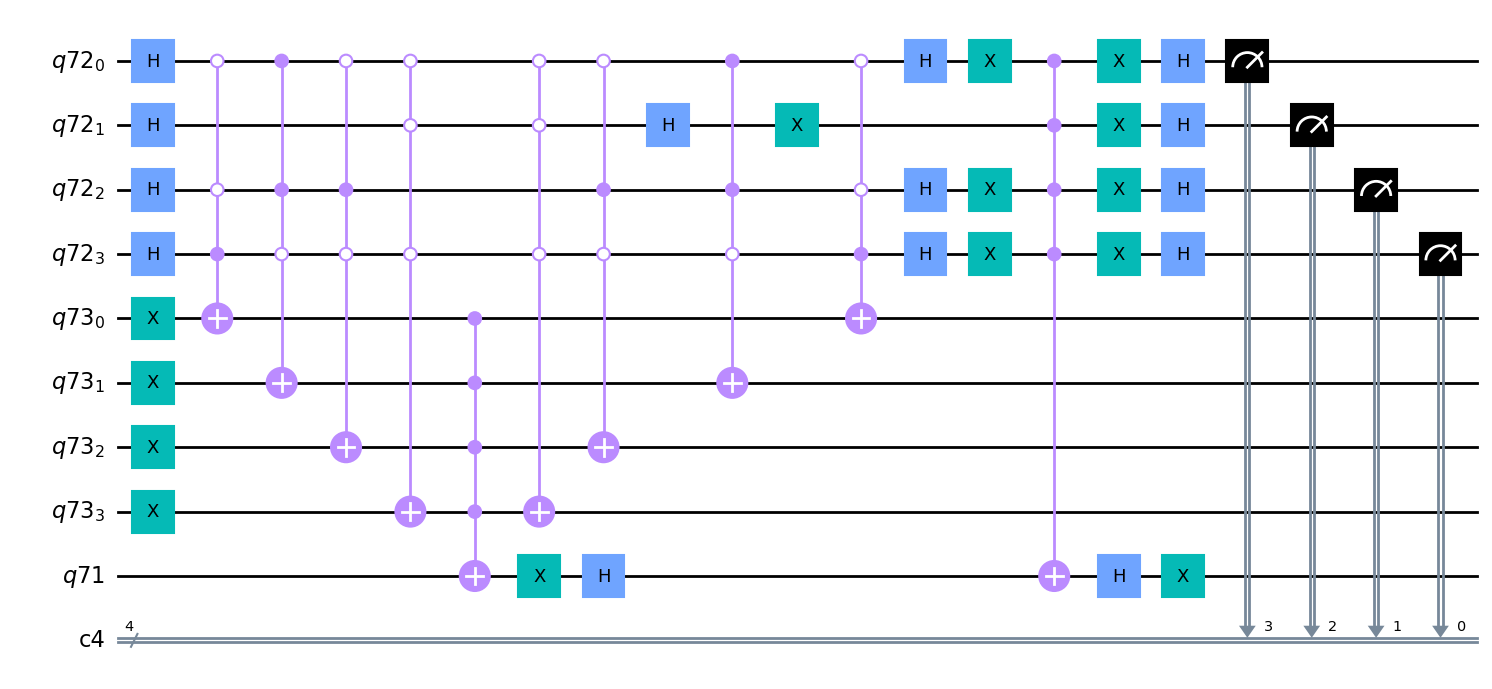

In [25]:
ans = QuantumRegister(1)
output = ClassicalRegister(n)
f_in = QuantumRegister(n)
aux = QuantumRegister(m)
qc = QuantumCircuit()
qc.add_register(f_in)
qc.add_register(aux)
qc.add_register(ans)
qc.add_register(output)
for i in range(n):
    qc.h(f_in[i])
for i in range(m):
    qc.x(aux[i])
p = 1
for p1 in range(p):
    sat_oracle(qc,n,m,clause_list,aux,f_in,ans)
    diffuser(qc,f_in,n,ans)
    
j = n-1
for i in range(n):
    qc.measure(f_in[i],output[j])
    j = j-1
    
qc.draw('mpl', style="clifford")

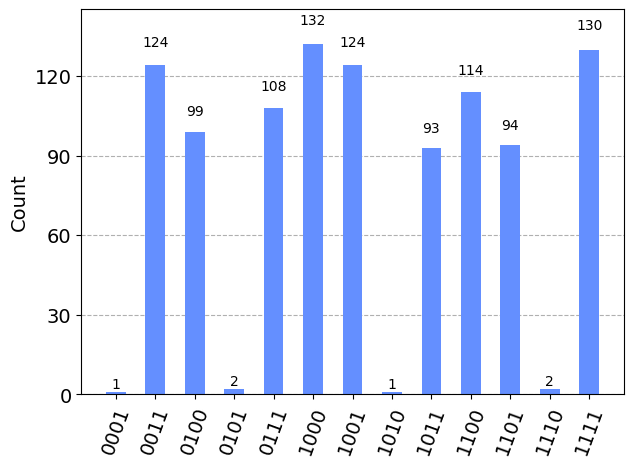

In [26]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

In [27]:
n = 4
m = 8
cnfC = CNF_Creator(n) # n is number of symbols 
clause_list = cnfC.CreateRandomSentence(m) # m is number of clauses in the sentence
print((clause_list))

[[-4, -3, 1], [-4, -3, 2], [-4, -2, 1], [-3, -2, -1], [-3, -1, 2], [-2, -1, 3], [-2, 3, 4], [1, 2, 4]]


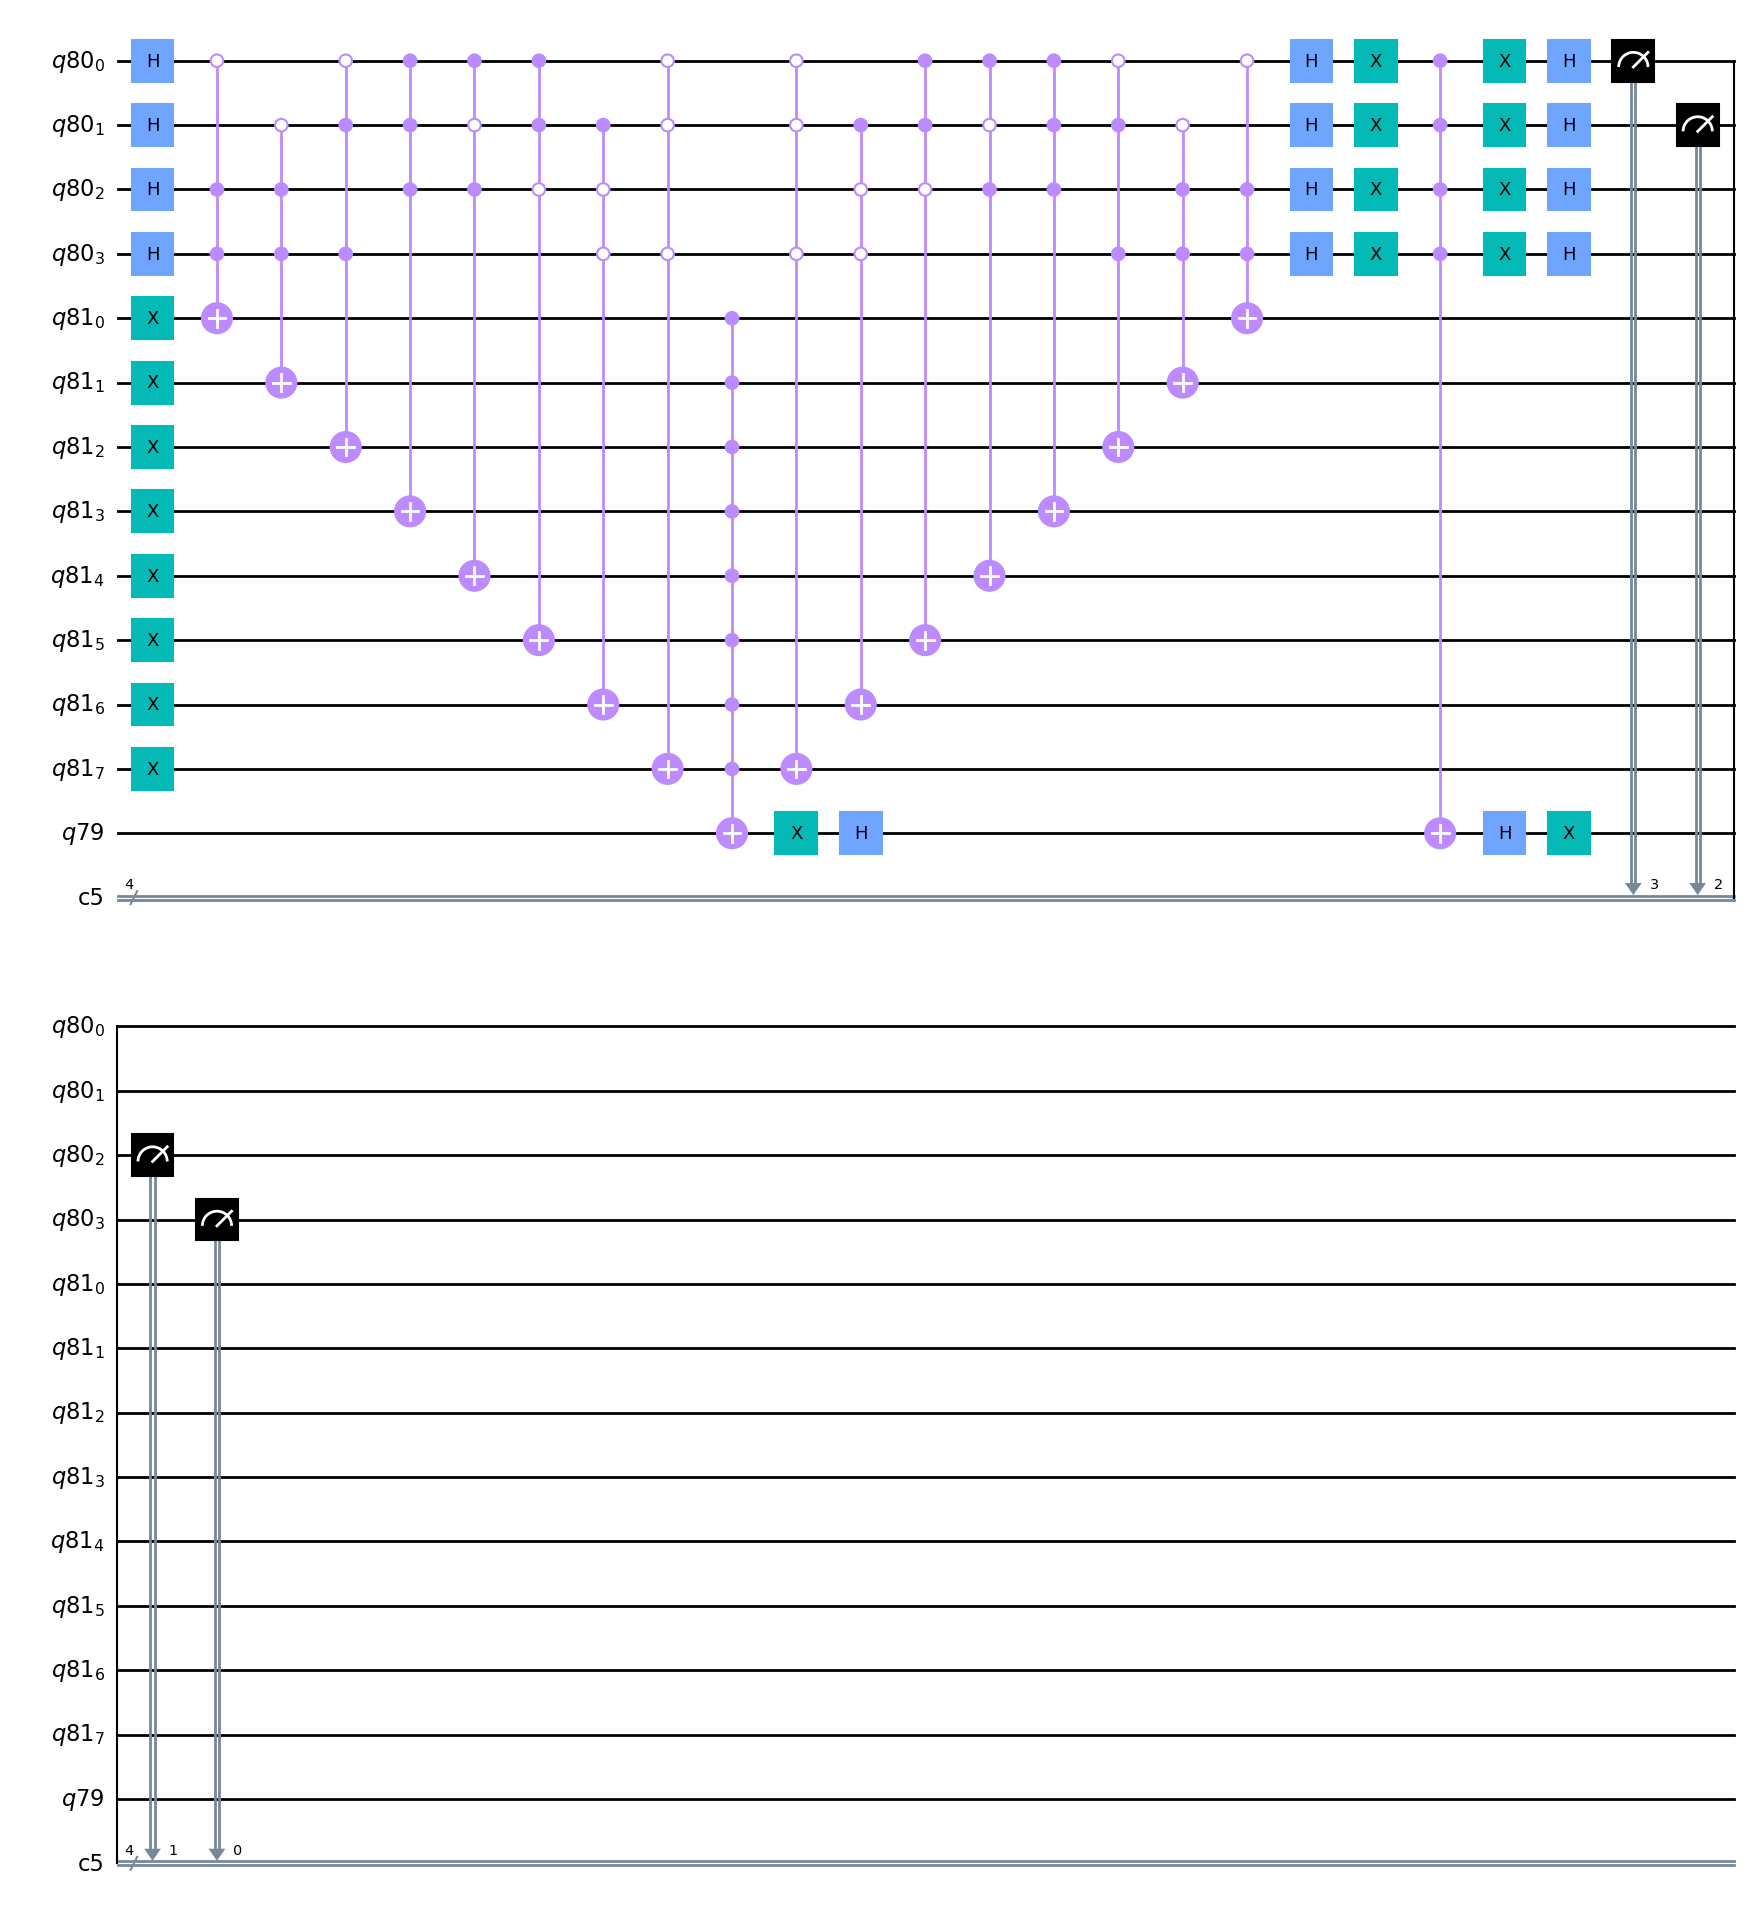

In [28]:
ans = QuantumRegister(1)
output = ClassicalRegister(n)
f_in = QuantumRegister(n)
aux = QuantumRegister(m)
qc = QuantumCircuit()
qc.add_register(f_in)
qc.add_register(aux)
qc.add_register(ans)
qc.add_register(output)
for i in range(n):
    qc.h(f_in[i])
for i in range(m):
    qc.x(aux[i])
p = 1
for p1 in range(p):
    sat_oracle(qc,n,m,clause_list,aux,f_in,ans)
    diffuser(qc,f_in,n,ans)

j = n-1
for i in range(n):
    qc.measure(f_in[i],output[j])
    j = j-1
    
qc.draw('mpl', style="clifford")

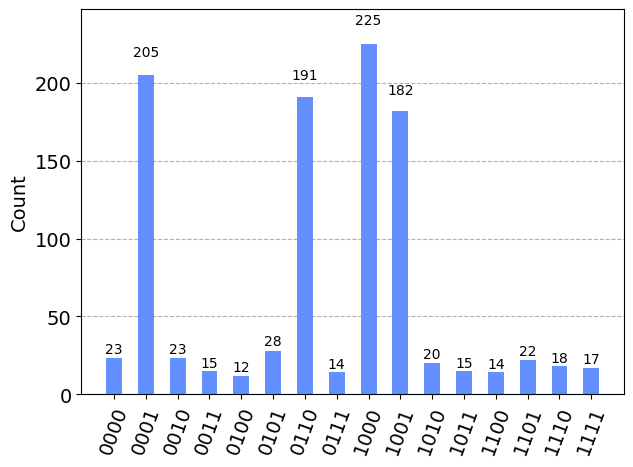

In [29]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

In [30]:
n = 4
m = 12
cnfC = CNF_Creator(n) # n is number of symbols 
clause_list = cnfC.CreateRandomSentence(m) # m is number of clauses in the sentence
print((clause_list))

[[-4, -3, -1], [-4, -2, -1], [-4, 1, 2], [-4, 2, 3], [-3, -2, -1], [-3, 1, 2], [-3, 1, 4], [-3, 2, 4], [-2, -1, 4], [-1, 2, 4], [-1, 3, 4], [1, 3, 4]]


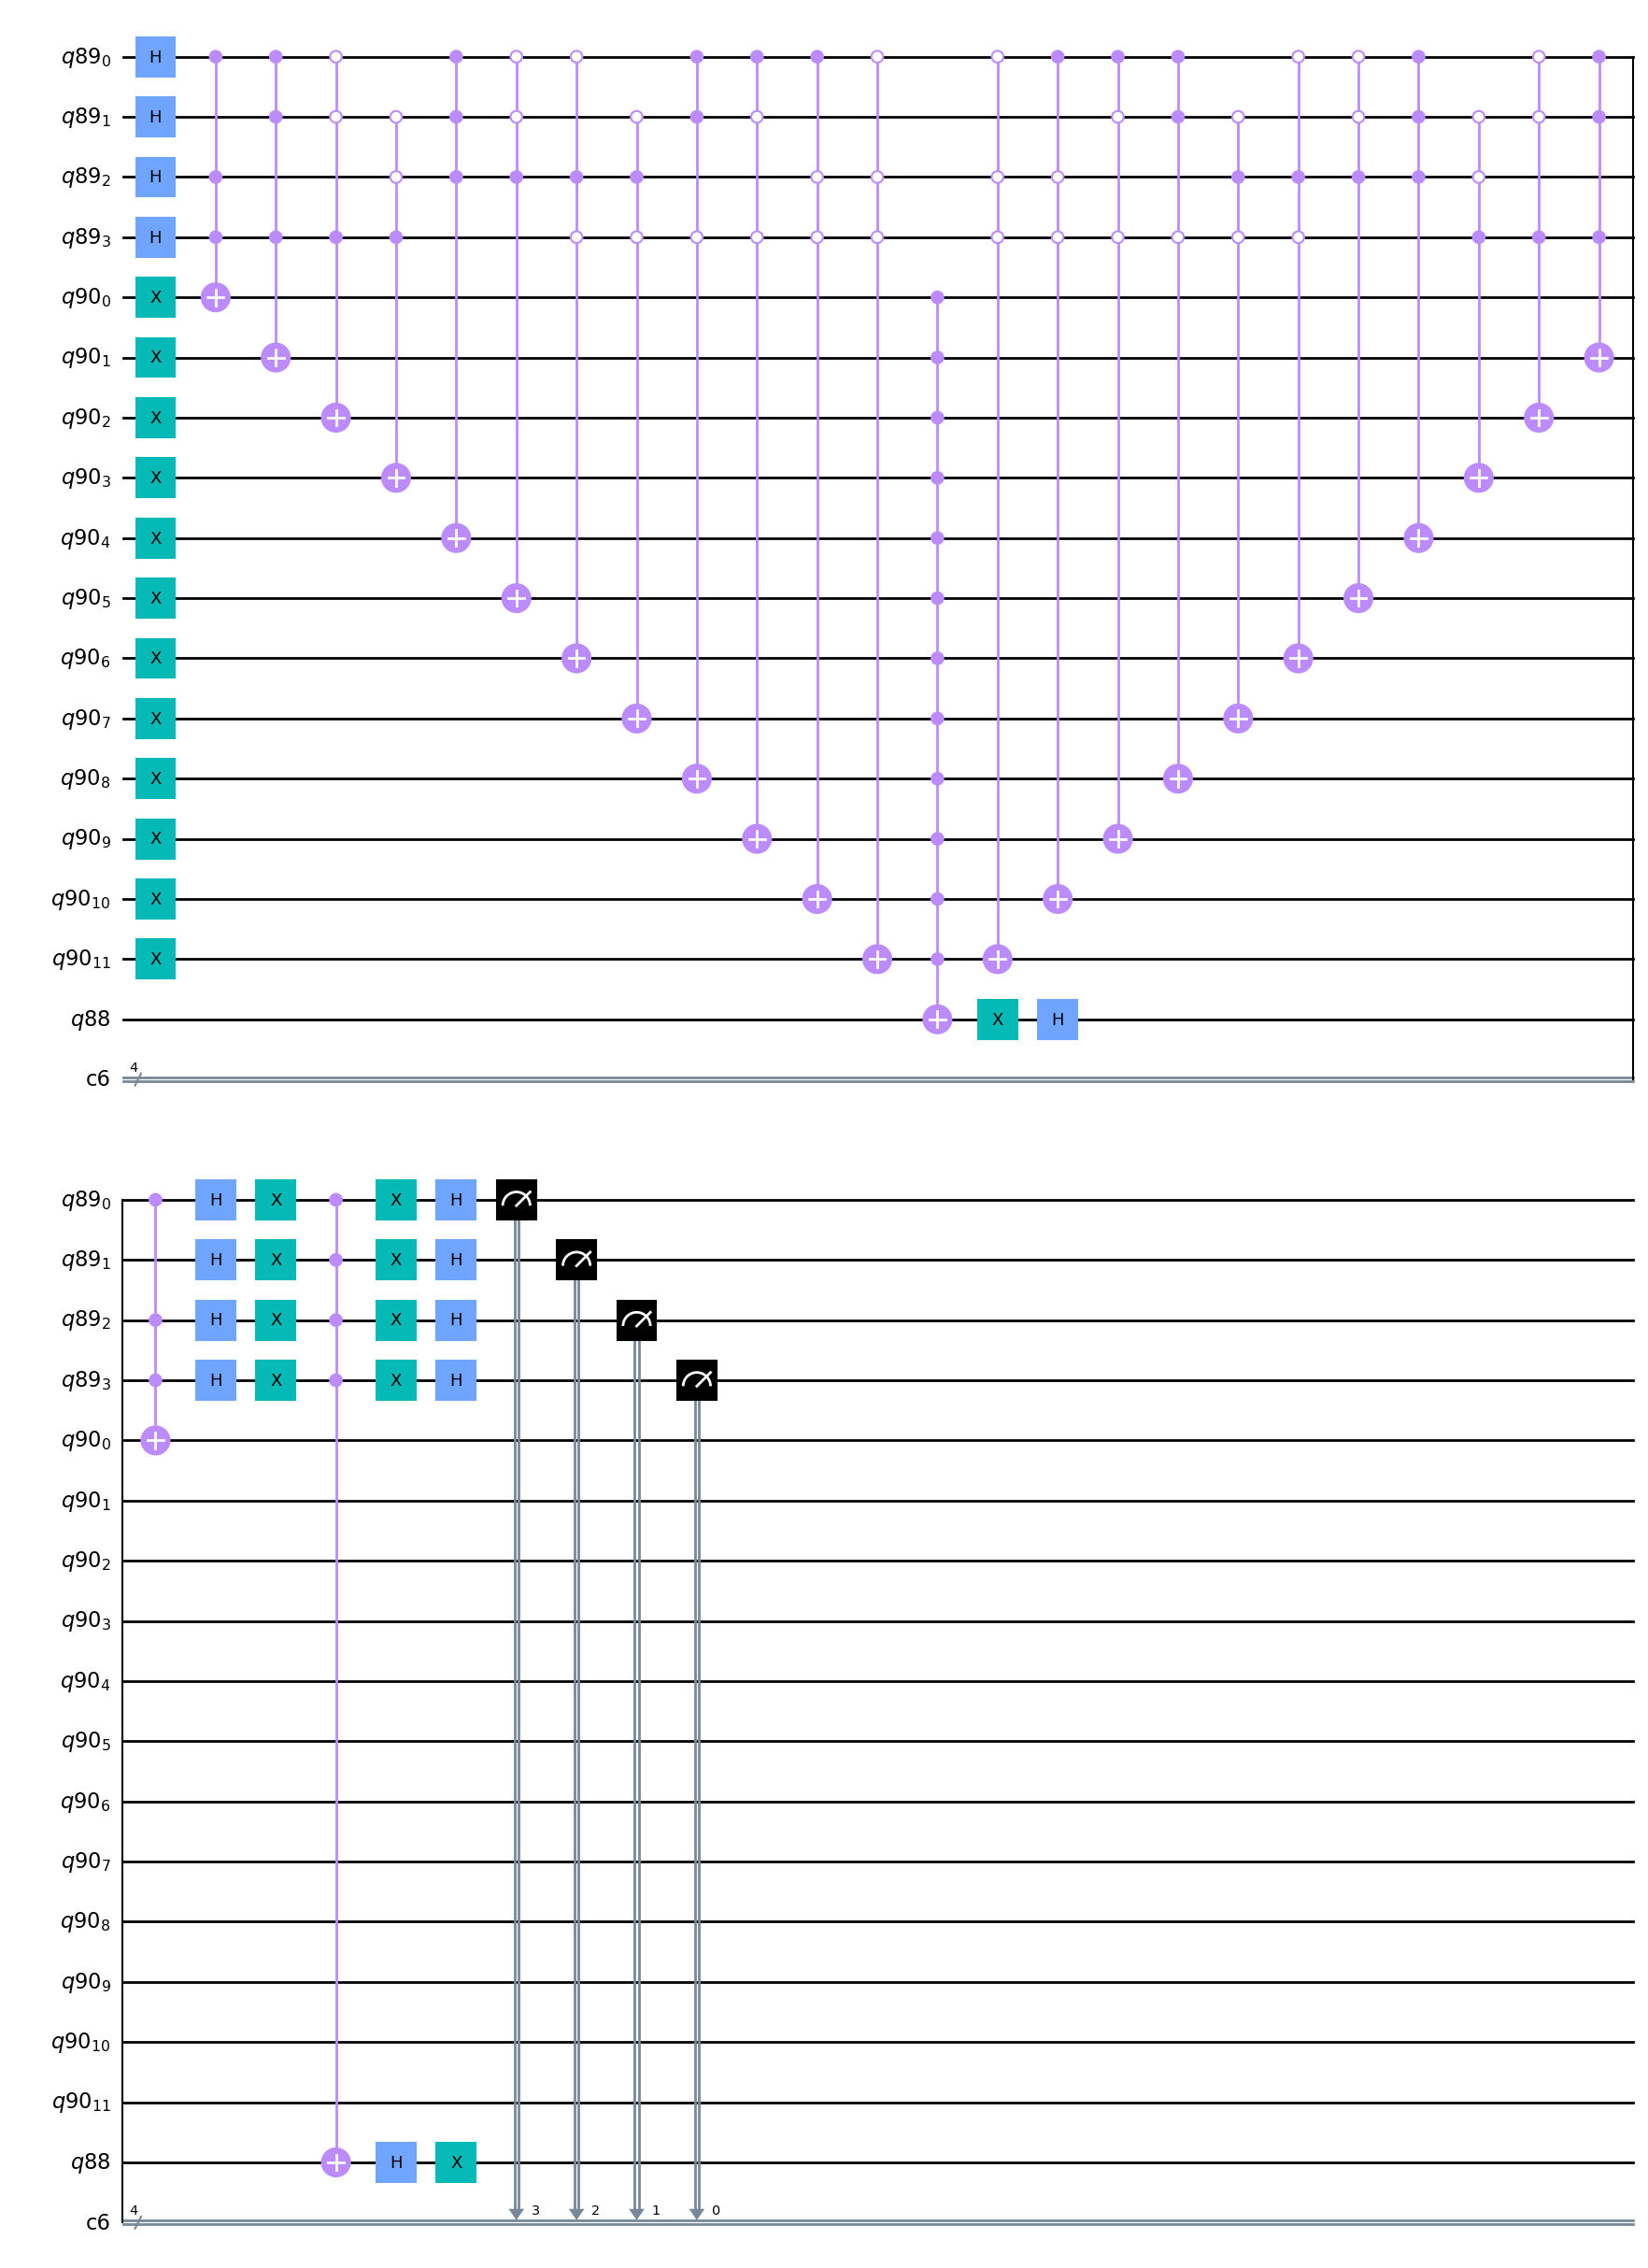

In [31]:
ans = QuantumRegister(1)
output = ClassicalRegister(n)
f_in = QuantumRegister(n)
aux = QuantumRegister(m)
qc = QuantumCircuit()
qc.add_register(f_in)
qc.add_register(aux)
qc.add_register(ans)
qc.add_register(output)
for i in range(n):
    qc.h(f_in[i])
for i in range(m):
    qc.x(aux[i])
p = 1
for p1 in range(p):
    sat_oracle(qc,n,m,clause_list,aux,f_in,ans)
    diffuser(qc,f_in,n,ans)
j = n-1
for i in range(n):
    qc.measure(f_in[i],output[j])
    j = j-1
    
qc.draw('mpl', style="clifford")

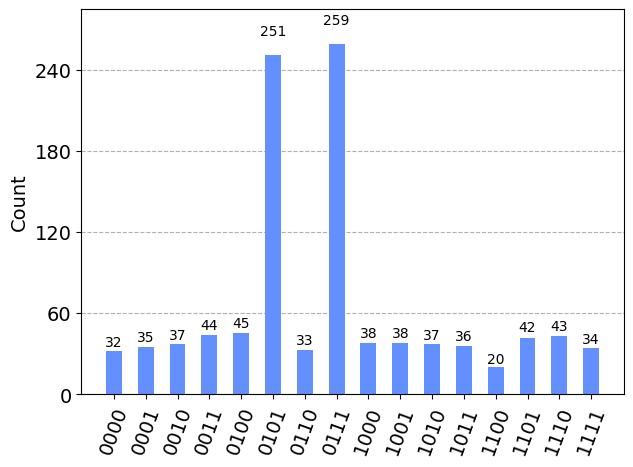

In [32]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

In [33]:
n = 4
m = 16
cnfC = CNF_Creator(n) # n is number of symbols 
clause_list = cnfC.CreateRandomSentence(m) # m is number of clauses in the sentence
print((clause_list))

[[-4, -3, -2], [-4, -2, -1], [-4, -2, 3], [-4, -1, 2], [-4, -1, 3], [-4, 1, 3], [-3, -2, -1], [-3, -2, 1], [-3, -2, 4], [-3, -1, 4], [-3, 1, 4], [-3, 2, 4], [-2, 1, 3], [-1, 2, 3], [-1, 3, 4], [1, 3, 4]]


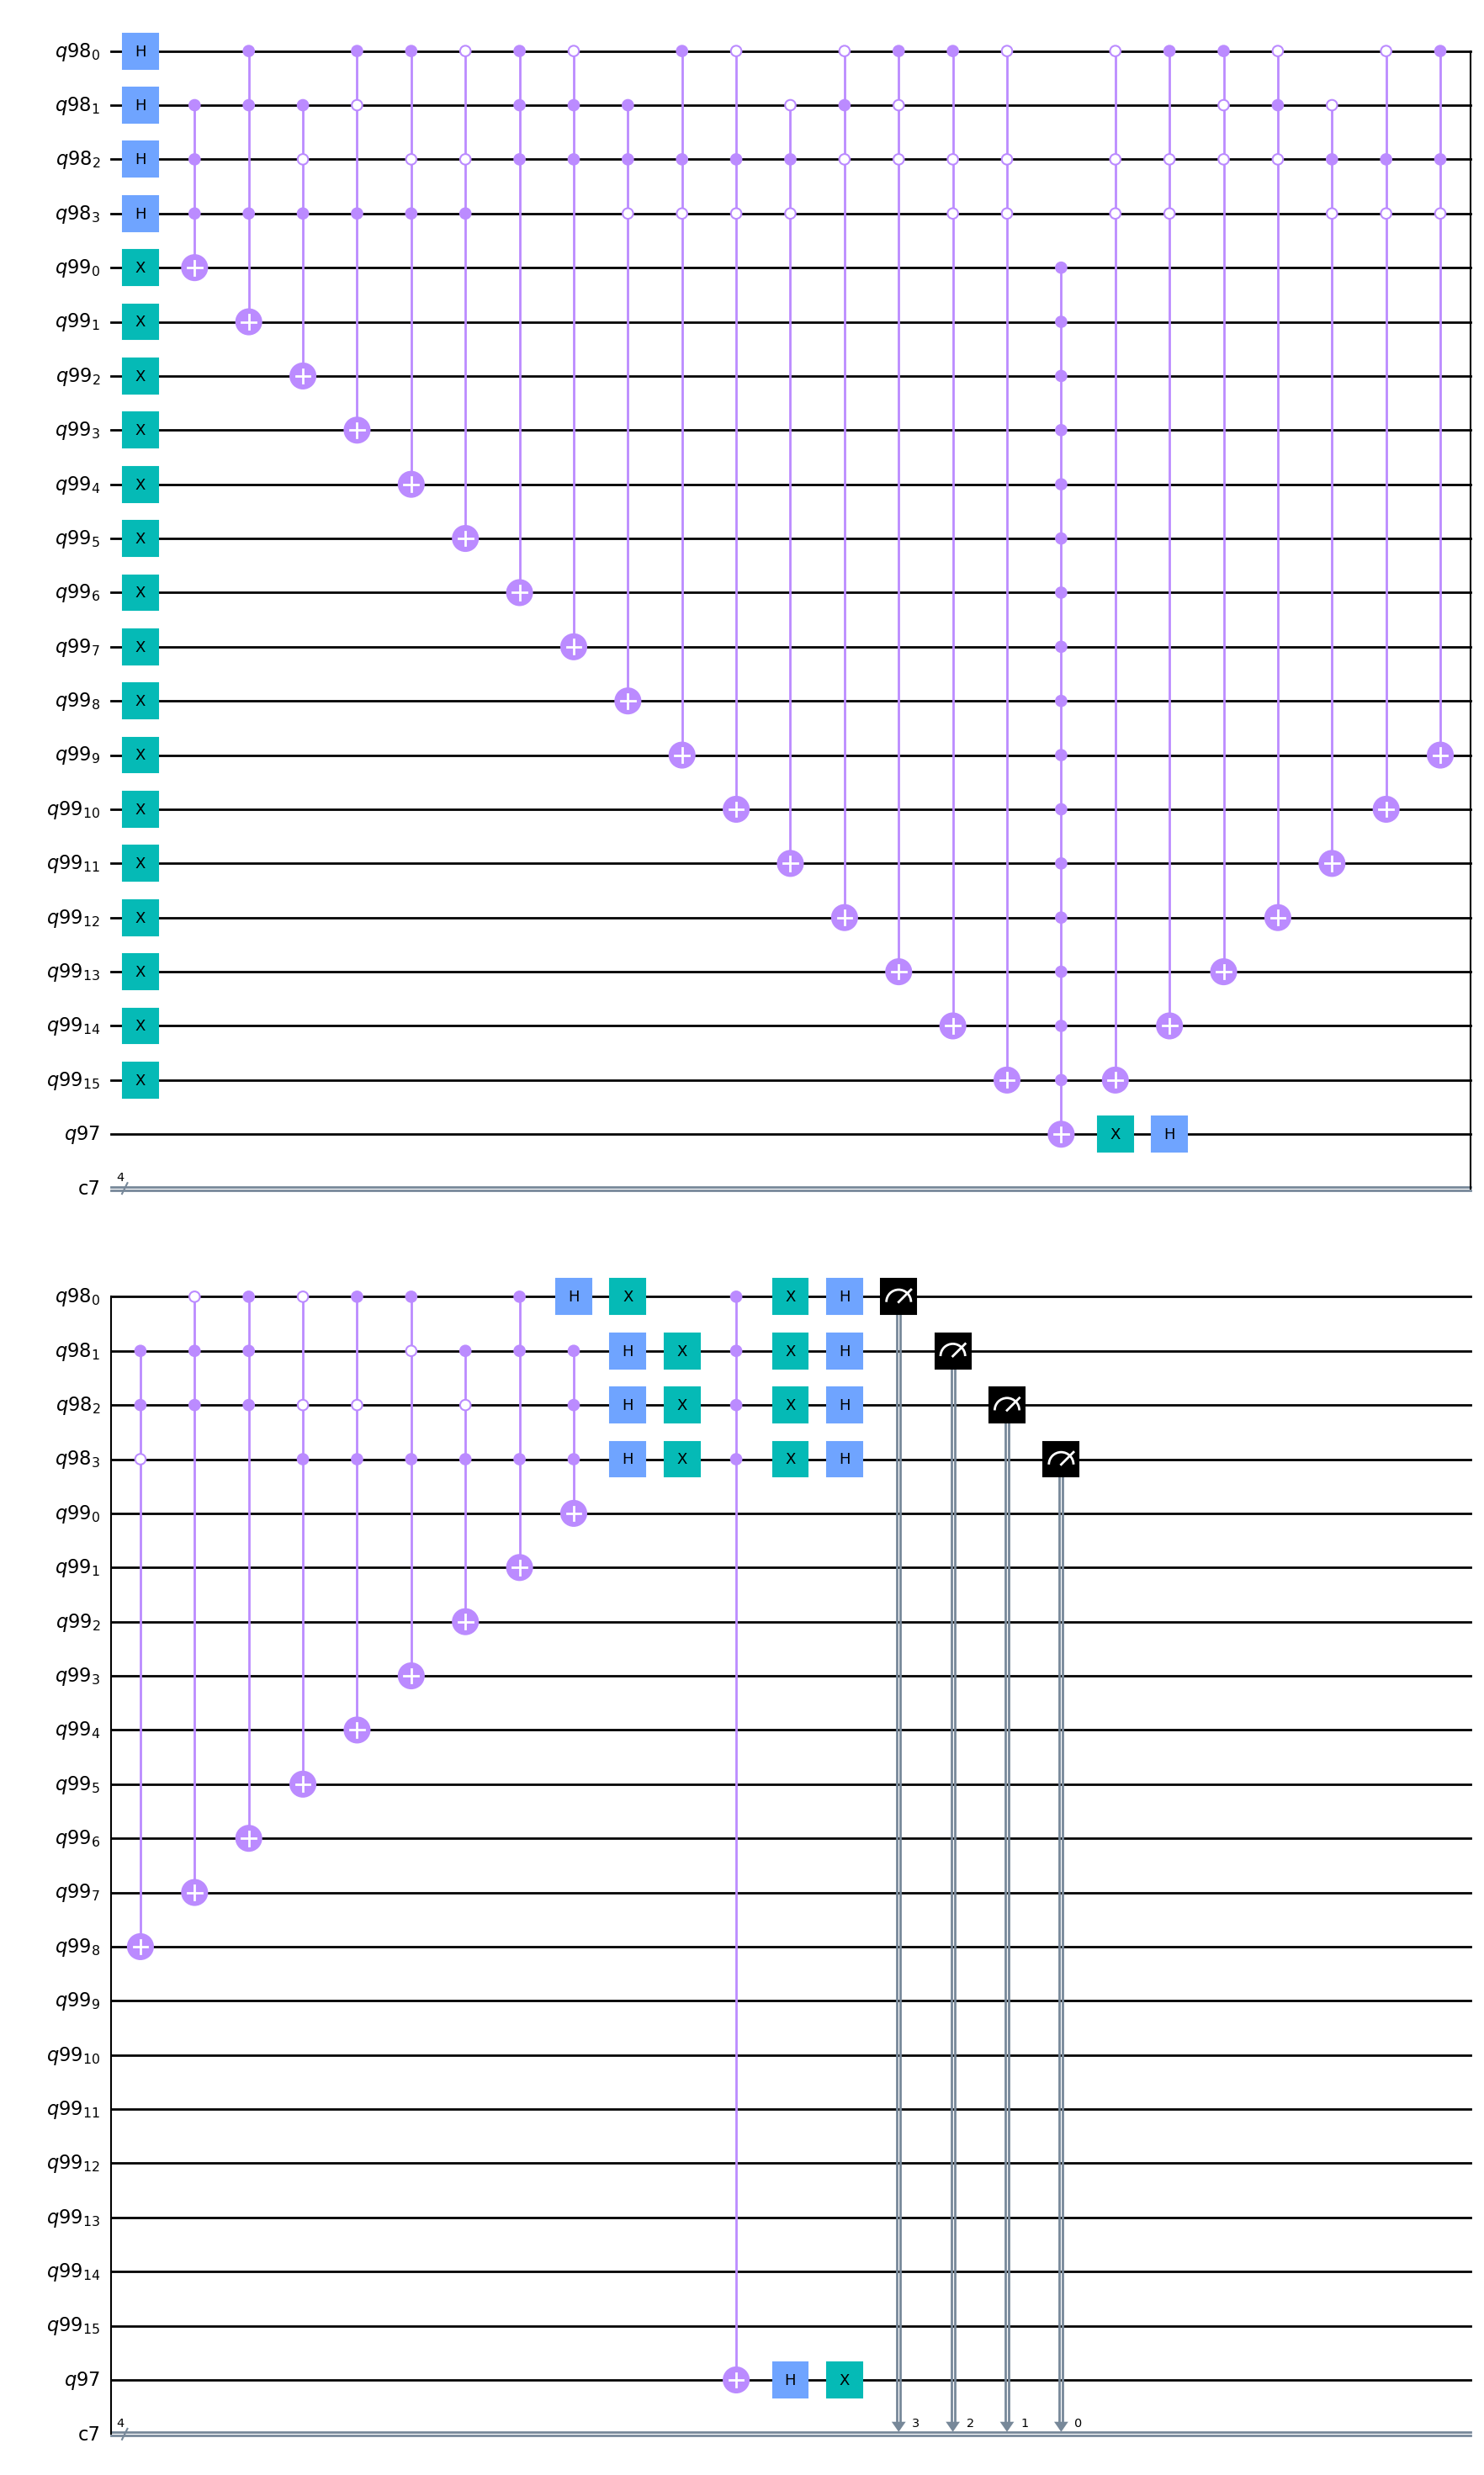

In [34]:
ans = QuantumRegister(1)
output = ClassicalRegister(n)
f_in = QuantumRegister(n)
aux = QuantumRegister(m)
qc = QuantumCircuit()
qc.add_register(f_in)
qc.add_register(aux)
qc.add_register(ans)
qc.add_register(output)
for i in range(n):
    qc.h(f_in[i])
for i in range(m):
    qc.x(aux[i])
p = 1
for p1 in range(p):
    sat_oracle(qc,n,m,clause_list,aux,f_in,ans)
    diffuser(qc,f_in,n,ans)

j = n-1
for i in range(n):
    qc.measure(f_in[i],output[j])
    j = j-1

    
qc.draw('mpl', style="clifford")

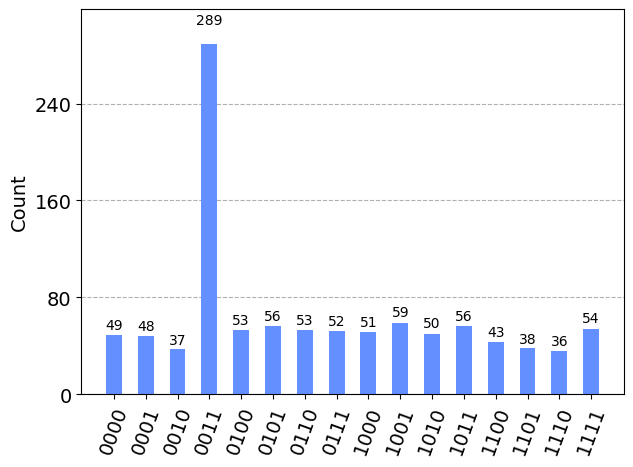

In [35]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

In [36]:
n = 4
m = 18
cnfC = CNF_Creator(n) # n is number of symbols 
clause_list = cnfC.CreateRandomSentence(m) # m is number of clauses in the sentence
print((clause_list))

[[-4, -3, -2], [-4, -3, 1], [-4, -3, 2], [-4, -2, 1], [-4, -1, 3], [-4, 1, 2], [-4, 1, 3], [-4, 2, 3], [-3, -2, -1], [-3, -1, 4], [-3, 1, 2], [-3, 1, 4], [-3, 2, 4], [-2, -1, 4], [-2, 3, 4], [-1, 2, 3], [1, 2, 4], [2, 3, 4]]


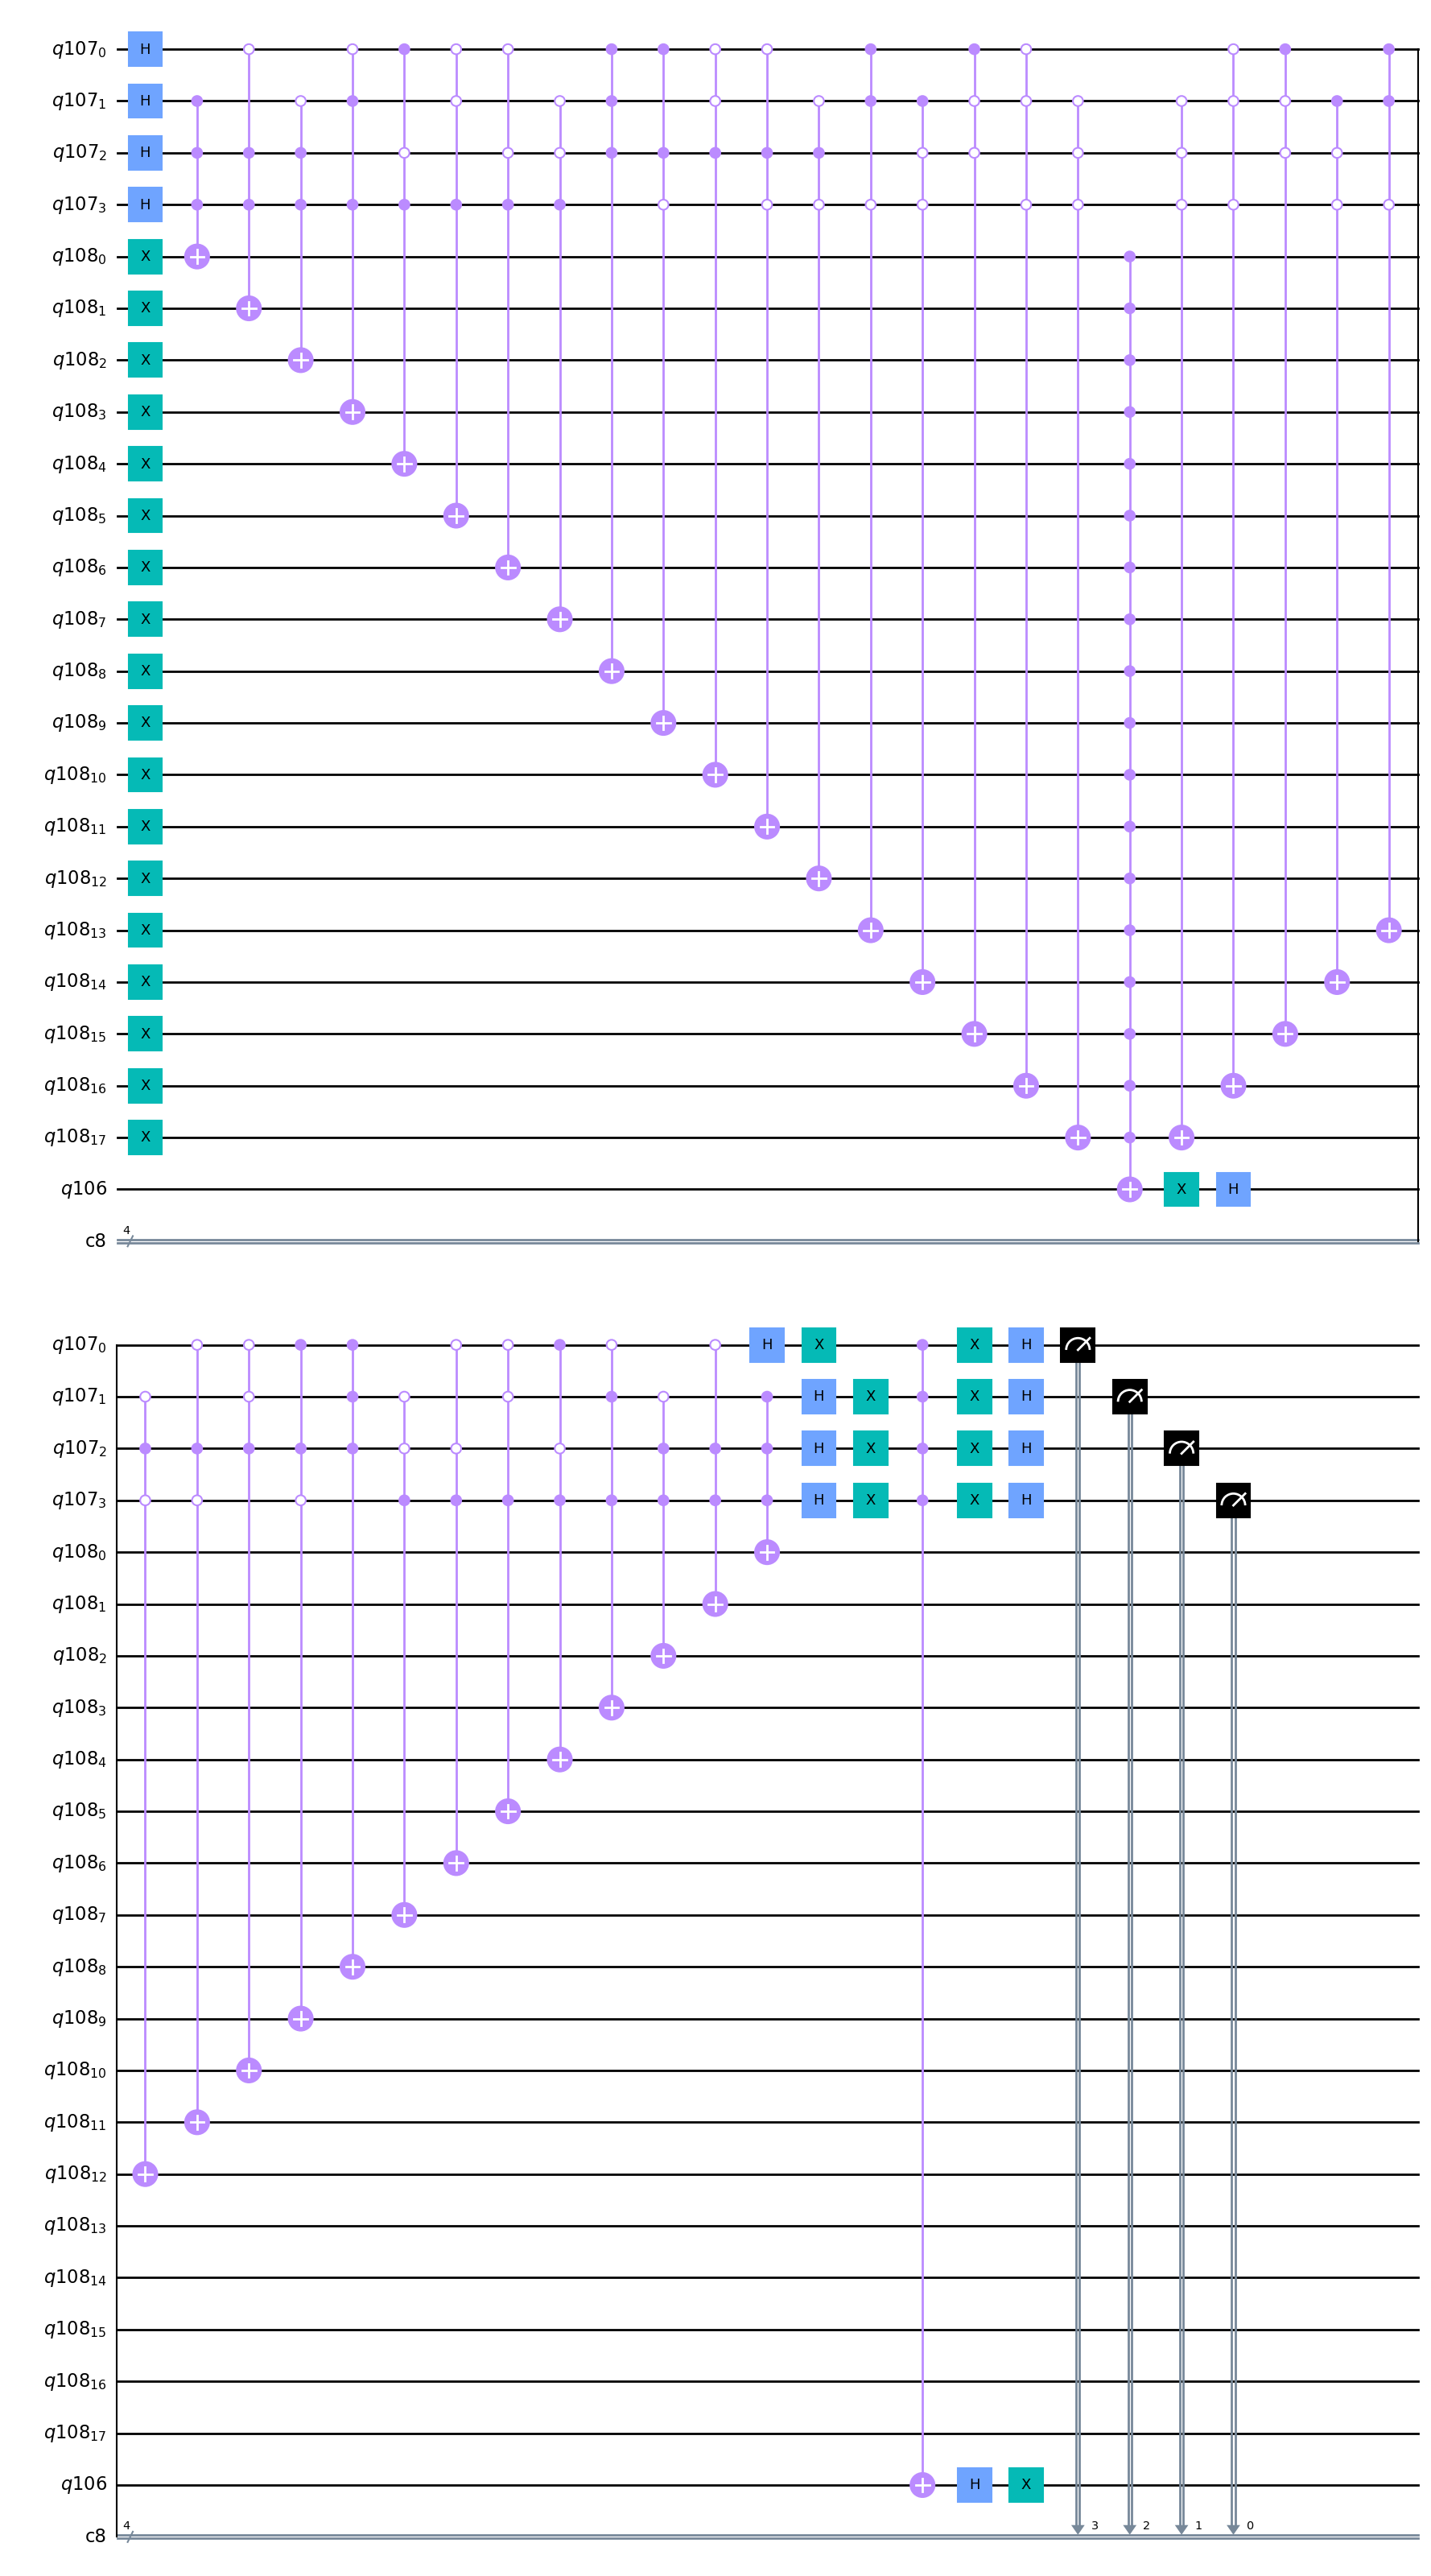

In [37]:
ans = QuantumRegister(1)
output = ClassicalRegister(n)
f_in = QuantumRegister(n)
aux = QuantumRegister(m)
qc = QuantumCircuit()
qc.add_register(f_in)
qc.add_register(aux)
qc.add_register(ans)
qc.add_register(output)
for i in range(n):
    qc.h(f_in[i])
for i in range(m):
    qc.x(aux[i])
p = 1
for p1 in range(p):
    sat_oracle(qc,n,m,clause_list,aux,f_in,ans)
    diffuser(qc,f_in,n,ans)

j = n-1
for i in range(n):
    qc.measure(f_in[i],output[j])
    j = j-1

    
qc.draw('mpl', style="clifford")

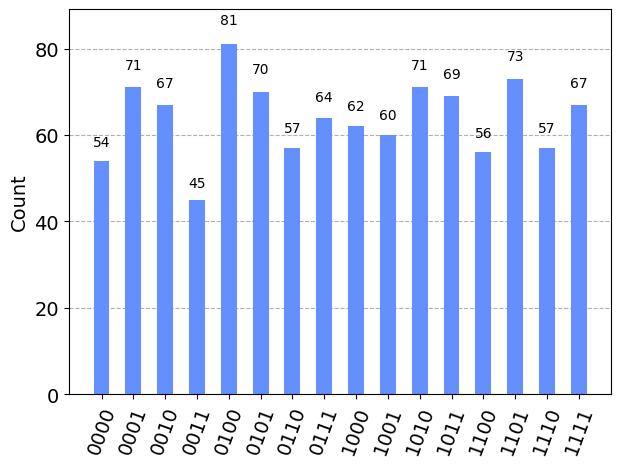

In [38]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())